<a href="https://colab.research.google.com/github/PhazeRoOman/DeepDTA/blob/Menna's-branch/DeepDTA_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DeepDTA: deep drug–target binding affinity prediction**

Source: https://github.com/hkmztrk/DeepDTA

In [1]:
!python --version

Python 3.10.12


In [ ]:
!pip install pydot
!pip install pydot_ng
!pip install
!pip install plot_model

Imports:

In [25]:
import os
import decimal
import argparse
import subprocess
import numpy as np
import tensorflow as tf
import random as rn
import sys, pickle
import math, json, time
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from random import shuffle
from collections import OrderedDict
from copy import deepcopy
from sklearn import preprocessing
from __future__ import print_function
from itertools import product
from collections import namedtuple
import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras.layers import Conv2D, GRU
from keras.layers import Input, Embedding, LSTM, TimeDistributed, Masking, RepeatVector, Flatten
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers, layers

In [3]:
#update the package lists
!sudo apt-get update -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [979 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,236 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [876 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [49.8 kB]
Get:13 http://archive.

In [4]:
#print tensorflow version
print(tf.__version__)

2.12.0


In [5]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(0)

TABSY = "\t"
figdir = "figures/"

In [6]:
!git clone https://github.com/PhazeRoOman/DeepDTA.git

Cloning into 'DeepDTA'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 447 (delta 38), reused 29 (delta 29), pack-reused 398
Receiving objects: 100% (447/447), 11.00 MiB | 4.80 MiB/s, done.
Resolving deltas: 100% (179/179), done.


In [7]:
%cd /content/DeepDTA

/content/DeepDTA


In [8]:
!ls

data  deepdta-toy  docs  README.md  source


In [9]:
#Arguments functions
def argparser():
  parser = argparse.ArgumentParser()
  # for model
  parser.add_argument(
      '--seq_window_lengths',
      type=int,
      nargs='+',
      help='Space seperated list of motif filter lengths. (ex, --window_lengths 4 8 12)'
  )
  parser.add_argument(
      '--smi_window_lengths',
      type=int,
      nargs='+',
      help='Space seperated list of motif filter lengths. (ex, --window_lengths 4 8 12)'
  )
  parser.add_argument(
      '--num_windows',
      type=int,
      nargs='+',
      help='Space seperated list of the number of motif filters corresponding to length list. (ex, --num_windows 100 200 100)'
  )
  parser.add_argument(
      '--num_hidden',
      type=int,
      default=0,
      help='Number of neurons in hidden layer.'
  )
  parser.add_argument(
      '--num_classes',
      type=int,
      default=0,
      help='Number of classes (families).'
  )
  parser.add_argument(
      '--max_seq_len',
      type=int,
      default=0,
      help='Length of input sequences.'
  )
  parser.add_argument(
      '--max_smi_len',
      type=int,
      default=0,
      help='Length of input sequences.'
  )
  # for learning
  parser.add_argument(
      '--learning_rate',
      type=float,
      default=0.001,
      help='Initial learning rate.'
  )
  parser.add_argument(
      '--num_epoch',
      type=int,
      default=100,
      help='Number of epochs to train.'
  )
  parser.add_argument(
      '--batch_size',
      type=int,
      default=256,
      help='Batch size. Must divide evenly into the dataset sizes.'
  )
  parser.add_argument(
      '--dataset_path',
      type=str,
      default='/data/kiba/',
      help='Directory for input data.'
  )
  parser.add_argument(
      '--problem_type',
      type=int,
      default=1,
      help='Type of the prediction problem (1-4)'
  )
  parser.add_argument(
      '--binary_th',
      type=float,
      default=0.0,
      help='Threshold to split data into binary classes'
  )
  parser.add_argument(
      '--is_log',
      type=int,
      default=0,
      help='use log transformation for Y'
  )
  parser.add_argument(
      '--checkpoint_path',
      type=str,
      default='',
      help='Path to write checkpoint file.'
  )
  parser.add_argument(
      '--log_dir',
      type=str,
      default='/tmp',
      help='Directory for log data.'
  )

  FLAGS, unparsed = parser.parse_known_args()

  # check validity
  #assert( len(FLAGS.window_lengths) == len(FLAGS.num_windows) )

  return FLAGS

def logging(msg, FLAGS):
  fpath = os.path.join( FLAGS.log_dir, "log.txt" )
  with open( fpath, "a" ) as fw:
    fw.write("%s\n" % msg)
  #print(msg)

In [10]:
#emetrics functions
def get_aupr(Y, P):
    if hasattr(Y, 'A'): Y = Y.A
    if hasattr(P, 'A'): P = P.A
    Y = np.where(Y>0, 1, 0)
    Y = Y.ravel()
    P = P.ravel()
    f = open("temp.txt", 'w')
    for i in range(Y.shape[0]):
        f.write("%f %d\n" %(P[i], Y[i]))
    f.close()
    f = open("foo.txt", 'w')
    subprocess.call(["java", "-jar", "auc.jar", "temp.txt", "list"], stdout=f)
    f.close()
    f = open("foo.txt")
    lines = f.readlines()
    aucpr = float(lines[-2].split()[-1])
    f.close()
    return aucpr



def get_cindex(Y, P):
    summ = 0
    pair = 0

    for i in range(1, len(Y)):
        for j in range(0, i):
            if i != j:
                if(Y[i] > Y[j]):
                    pair +=1
                    summ +=  1* (P[i] > P[j]) + 0.5 * (P[i] == P[j])


    if pair != 0:
        return summ/pair
    else:
        return 0


def r_squared_error(y_obs,y_pred):
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    y_pred_mean = [np.mean(y_pred) for y in y_pred]

    mult = sum((y_pred - y_pred_mean) * (y_obs - y_obs_mean))
    mult = mult * mult

    y_obs_sq = sum((y_obs - y_obs_mean)*(y_obs - y_obs_mean))
    y_pred_sq = sum((y_pred - y_pred_mean) * (y_pred - y_pred_mean) )

    return mult / float(y_obs_sq * y_pred_sq)


def get_k(y_obs,y_pred):
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)

    return sum(y_obs*y_pred) / float(sum(y_pred*y_pred))


def squared_error_zero(y_obs,y_pred):
    k = get_k(y_obs,y_pred)

    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    upp = sum((y_obs - (k*y_pred)) * (y_obs - (k* y_pred)))
    down= sum((y_obs - y_obs_mean)*(y_obs - y_obs_mean))

    return 1 - (upp / float(down))


def get_rm2(ys_orig,ys_line):
    r2 = r_squared_error(ys_orig, ys_line)
    r02 = squared_error_zero(ys_orig, ys_line)

    return r2 * (1 - np.sqrt(np.absolute((r2*r2)-(r02*r02))))

In [11]:
def build_combined_onehot(FLAGS, NUM_FILTERS, FILTER_LENGTH1, FILTER_LENGTH2):
    XDinput = Input(shape=(FLAGS.max_smi_len, FLAGS.charsmiset_size))
    XTinput = Input(shape=(FLAGS.max_seq_len, FLAGS.charseqset_size))


    encode_smiles= Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1)(XDinput)
    encode_smiles = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = GlobalMaxPooling1D()(encode_smiles) #pool_size=pool_length[i]


    encode_protein = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1)(XTinput)
    encode_protein = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = GlobalMaxPooling1D()(encode_protein)



    encode_interaction = keras.layers.concatenate([encode_smiles, encode_protein])
    #encode_interaction = keras.layers.concatenate([encode_smiles, encode_protein], axis=-1) #merge.Add()([encode_smiles, encode_protein])

    # Fully connected
    FC1 = Dense(1024, activation='relu')(encode_interaction)
    FC2 = Dropout(0.1)(FC1)
    FC2 = Dense(1024, activation='relu')(FC2)
    FC2 = Dropout(0.1)(FC2)
    FC2 = Dense(512, activation='relu')(FC2)


    predictions = Dense(1, kernel_initializer='normal')(FC2)

    interactionModel = Model(inputs=[XDinput, XTinput], outputs=[predictions])
    interactionModel.compile(optimizer='adam', loss='mean_squared_error', metrics=[cindex_score]) #, metrics=['cindex_score']


    print(interactionModel.summary())
    plot_model(interactionModel, to_file='figures/build_combined_onehot.png')

    return interactionModel

In [12]:
def build_combined_categorical(FLAGS, NUM_FILTERS, FILTER_LENGTH1, FILTER_LENGTH2):

    XDinput = Input(shape=(FLAGS.max_smi_len,), dtype='int32') ### Buralar flagdan gelmeliii
    XTinput = Input(shape=(FLAGS.max_seq_len,), dtype='int32')

    ### SMI_EMB_DINMS  FLAGS GELMELII
    encode_smiles = Embedding(input_dim=FLAGS.charsmiset_size+1, output_dim=128, input_length=FLAGS.max_smi_len)(XDinput)
    encode_smiles = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = GlobalMaxPooling1D()(encode_smiles)


    encode_protein = Embedding(input_dim=FLAGS.charseqset_size+1, output_dim=128, input_length=FLAGS.max_seq_len)(XTinput)
    encode_protein = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = GlobalMaxPooling1D()(encode_protein)


    encode_interaction = keras.layers.concatenate([encode_smiles, encode_protein], axis=-1) #merge.Add()([encode_smiles, encode_protein])

    # Fully connected
    FC1 = Dense(1024, activation='relu')(encode_interaction)
    FC2 = Dropout(0.1)(FC1)
    FC2 = Dense(1024, activation='relu')(FC2)
    FC2 = Dropout(0.1)(FC2)
    FC2 = Dense(512, activation='relu')(FC2)


    # And add a logistic regression on top
    predictions = Dense(1, kernel_initializer='normal')(FC2) #OR no activation, rght now it's between 0-1, do I want this??? activation='sigmoid'

    interactionModel = Model(inputs=[XDinput, XTinput], outputs=[predictions])

    interactionModel.compile(optimizer='adam', loss='mean_squared_error', metrics=[cindex_score]) #, metrics=['cindex_score']
    print(interactionModel.summary())
    # plot_model(interactionModel, to_file='figures/build_combined_categorical.png')

    return interactionModel

In [13]:
def build_single_drug(FLAGS, NUM_FILTERS, FILTER_LENGTH1, FILTER_LENGTH2):

    interactionModel = Sequential()
    XTmodel = Sequential()
    XTmodel.add(Activation('linear', input_shape=(FLAGS.target_count,)))


    encode_smiles = Sequential()
    encode_smiles.add(Embedding(input_dim=FLAGS.charsmiset_size+1, output_dim=128, input_length=FLAGS.max_smi_len))
    encode_smiles.add(Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1)) #input_shape=(MAX_SMI_LEN, SMI_EMBEDDING_DIMS)
    encode_smiles.add(Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1))
    encode_smiles.add(Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1))
    encode_smiles.add(GlobalMaxPooling1D())


    # interactionModel.add(Merge([encode_smiles, XTmodel], mode='concat', concat_axis=1))
    # #interactionModel.add(layers.merge.Concatenate([XDmodel, XTmodel]))
    interactionModel.add(layers.Concatenate([encode_smiles, XTmodel]))

    # Fully connected
    interactionModel.add(Dense(1024, activation='relu')) #1024
    interactionModel.add(Dropout(0.1))
    interactionModel.add(Dense(1024, activation='relu')) #1024
    interactionModel.add(Dropout(0.1))
    interactionModel.add(Dense(512, activation='relu'))


    interactionModel.add(Dense(1, kernel_initializer='normal'))
    interactionModel.compile(optimizer='adam', loss='mean_squared_error', metrics=[cindex_score])

    print(interactionModel.summary())
    plot_model(interactionModel, to_file='figures/build_single_drug.png')

    return interactionModel

In [14]:
def build_single_prot(FLAGS, NUM_FILTERS, FILTER_LENGTH1, FILTER_LENGTH2):

    interactionModel = Sequential()
    XDmodel = Sequential()
    XDmodel.add(Activation('linear', input_shape=(FLAGS.drugcount,)))


    XTmodel1 = Sequential()
    XTmodel1.add(Embedding(input_dim=FLAGS.charseqset_size+1, output_dim=128,  input_length=FLAGS.max_seq_len))
    XTmodel1.add(Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1)) #input_shape=(MAX_SEQ_LEN, SEQ_EMBEDDING_DIMS)
    XTmodel1.add(Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1))
    XTmodel1.add(Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1))
    XTmodel1.add(GlobalMaxPooling1D())


    # interactionModel.add(Merge([XDmodel, XTmodel1], mode='concat', concat_axis=1))
    interactionModel.add(layers.Concatenate([XDmodel, XTmodel1]))


    # Fully connected
    interactionModel.add(Dense(1024, activation='relu'))
    interactionModel.add(Dropout(0.1))
    interactionModel.add(Dense(1024, activation='relu'))
    interactionModel.add(Dropout(0.1))
    interactionModel.add(Dense(512, activation='relu'))

    interactionModel.add(Dense(1, kernel_initializer='normal'))
    interactionModel.compile(optimizer='adam', loss='mean_squared_error', metrics=[cindex_score])

    print(interactionModel.summary())
    plot_model(interactionModel, to_file='figures/build_single_protein.png')

    return interactionModel

In [15]:
def build_baseline(FLAGS, NUM_FILTERS, FILTER_LENGTH1, FILTER_LENGTH2):
    interactionModel = Sequential()

    XDmodel = Sequential()
    XDmodel.add(Dense(1, activation='linear', input_shape=(FLAGS.drug_count, )))

    XTmodel = Sequential()
    XTmodel.add(Dense(1, activation='linear', input_shape=(FLAGS.target_count,)))


    # interactionModel.add(Merge([XDmodel, XTmodel], mode='concat', concat_axis=1))
    interactionModel.add(layers.Concatenate([XDmodel, XTmodel]))

    # Fully connected
    interactionModel.add(Dense(1024, activation='relu'))
    interactionModel.add(Dropout(0.1))
    interactionModel.add(Dense(1024, activation='relu'))
    interactionModel.add(Dropout(0.1))
    interactionModel.add(Dense(512, activation='relu'))

    interactionModel.add(Dense(1, kernel_initializer='normal'))
    interactionModel.compile(optimizer='adam', loss='mean_squared_error', metrics=[cindex_score])

    print(interactionModel.summary())
    plot_model(interactionModel, to_file='figures/build_baseline.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)

    # plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)
    # model = Sequential()
    # model.add(Dense(2, input_dim=1, activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    # plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return interactionModel

In [16]:
def nfold_1_2_3_setting_sample(XD, XT,  Y, label_row_inds, label_col_inds, measure, runmethod,  FLAGS, dataset):

    bestparamlist = []
    test_set, outer_train_sets = dataset.read_sets(FLAGS)

    foldinds = len(outer_train_sets)

    test_sets = []
    ## TRAIN AND VAL
    val_sets = []
    train_sets = []

    #logger.info('Start training')
    for val_foldind in range(foldinds):
        val_fold = outer_train_sets[val_foldind]
        val_sets.append(val_fold)
        otherfolds = deepcopy(outer_train_sets)
        otherfolds.pop(val_foldind)
        otherfoldsinds = [item for sublist in otherfolds for item in sublist]
        train_sets.append(otherfoldsinds)
        test_sets.append(test_set)
        print("val set", str(len(val_fold)))
        print("train set", str(len(otherfoldsinds)))



    bestparamind, best_param_list, bestperf, all_predictions_not_need, losses_not_need = general_nfold_cv(XD, XT,  Y, label_row_inds, label_col_inds,
                                                                                                measure, runmethod, FLAGS, train_sets, val_sets)

    #print("Test Set len", str(len(test_set)))
    #print("Outer Train Set len", str(len(outer_train_sets)))
    bestparam, best_param_list, bestperf, all_predictions, all_losses = general_nfold_cv(XD, XT,  Y, label_row_inds, label_col_inds,
                                                                                                measure, runmethod, FLAGS, train_sets, test_sets)

    testperf = all_predictions[bestparamind]##pointer pos

    logging("---FINAL RESULTS-----", FLAGS)
    logging("best param index = %s,  best param = %.5f" %
            (bestparamind, bestparam), FLAGS)


    testperfs = []
    testloss= []

    avgperf = 0.

    for test_foldind in range(len(test_sets)):
        foldperf = all_predictions[bestparamind][test_foldind]
        foldloss = all_losses[bestparamind][test_foldind]
        testperfs.append(foldperf)
        testloss.append(foldloss)
        avgperf += foldperf

    avgperf = avgperf / len(test_sets)
    avgloss = np.mean(testloss)
    teststd = np.std(testperfs)

    logging("Test Performance CI", FLAGS)
    logging(testperfs, FLAGS)
    logging("Test Performance MSE", FLAGS)
    logging(testloss, FLAGS)

    return avgperf, avgloss, teststd

In [17]:
def general_nfold_cv(XD, XT,  Y, label_row_inds, label_col_inds, prfmeasure, runmethod, FLAGS, labeled_sets, val_sets): ## BURAYA DA FLAGS LAZIM????

    paramset1 = FLAGS.num_windows                              #[32]#[32,  512] #[32, 128]  # filter numbers
    paramset2 = FLAGS.smi_window_lengths                               #[4, 8]#[4,  32] #[4,  8] #filter length smi
    paramset3 = FLAGS.seq_window_lengths                               #[8, 12]#[64,  256] #[64, 192]#[8, 192, 384]
    epoch = FLAGS.num_epoch                                 #100
    batchsz = FLAGS.batch_size                             #256

    logging("---Parameter Search-----", FLAGS)

    w = len(val_sets)
    h = len(paramset1) * len(paramset2) * len(paramset3)

    all_predictions = [[0 for x in range(w)] for y in range(h)]
    all_losses = [[0 for x in range(w)] for y in range(h)]
    print(all_predictions)

    for foldind in range(len(val_sets)):
        valinds = val_sets[foldind]
        labeledinds = labeled_sets[foldind]

        Y_train = np.mat(np.copy(Y))

        params = {}
        XD_train = XD
        XT_train = XT
        trrows = label_row_inds[labeledinds]
        trcols = label_col_inds[labeledinds]

        XD_train = XD[trrows]
        XT_train = XT[trcols]

        train_drugs, train_prots,  train_Y = prepare_interaction_pairs(XD, XT, Y, trrows, trcols)

        terows = label_row_inds[valinds]
        tecols = label_col_inds[valinds]
        #print("terows", str(terows), str(len(terows)))
        #print("tecols", str(tecols), str(len(tecols)))

        val_drugs, val_prots,  val_Y = prepare_interaction_pairs(XD, XT,  Y, terows, tecols)


        pointer = 0

        for param1ind in range(len(paramset1)): #hidden neurons
            param1value = paramset1[param1ind]
            for param2ind in range(len(paramset2)): #learning rate
                param2value = paramset2[param2ind]

                for param3ind in range(len(paramset3)):
                    param3value = paramset3[param3ind]

                    gridmodel = runmethod(FLAGS, param1value, param2value, param3value)
                    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
                    gridres = gridmodel.fit(([np.array(train_drugs),np.array(train_prots) ]), np.array(train_Y), batch_size=batchsz, epochs=epoch,
                            validation_data=( ([np.array(val_drugs), np.array(val_prots) ]), np.array(val_Y)),  shuffle=False, callbacks=[es] )


                    predicted_labels = gridmodel.predict([np.array(val_drugs), np.array(val_prots) ])
                    loss, rperf2 = gridmodel.evaluate(([np.array(val_drugs),np.array(val_prots) ]), np.array(val_Y), verbose=0)
                    rperf = prfmeasure(val_Y, predicted_labels)
                    rperf = rperf[0]


                    logging("P1 = %d,  P2 = %d, P3 = %d, Fold = %d, CI-i = %f, CI-ii = %f, MSE = %f" %
                    (param1ind, param2ind, param3ind, foldind, rperf, rperf2, loss), FLAGS)

                    plotLoss(gridres, param1ind, param2ind, param3ind, foldind)

                    all_predictions[pointer][foldind] =rperf #TODO FOR EACH VAL SET allpredictions[pointer][foldind]
                    all_losses[pointer][foldind]= loss

                    pointer +=1

    bestperf = -float('Inf')
    bestpointer = None


    best_param_list = []
    ##Take average according to folds, then chooose best params
    pointer = 0
    for param1ind in range(len(paramset1)):
            for param2ind in range(len(paramset2)):
                for param3ind in range(len(paramset3)):

                    avgperf = 0.
                    for foldind in range(len(val_sets)):
                        foldperf = all_predictions[pointer][foldind]
                        avgperf += foldperf
                    avgperf /= len(val_sets)
                    #print(epoch, batchsz, avgperf)
                    if avgperf > bestperf:
                        bestperf = avgperf
                        bestpointer = pointer
                        best_param_list = [param1ind, param2ind, param3ind]

                    pointer +=1

    return  bestpointer, best_param_list, bestperf, all_predictions, all_losses

In [18]:
def cindex_score(y_true, y_pred):

    g = tf.subtract(tf.expand_dims(y_pred, -1), y_pred)
    g = tf.cast(g == 0.0, tf.float32) * 0.5 + tf.cast(g > 0.0, tf.float32)

    f = tf.subtract(tf.expand_dims(y_true, -1), y_true) > 0.0
    f = tf.compat.v1.matrix_band_part(tf.cast(f, tf.float32), -1, 0)

    g = tf.reduce_sum(tf.multiply(g, f))
    f = tf.reduce_sum(f)

    return tf.where(tf.equal(g, 0), 0.0, g/f) #select

In [19]:
def plotLoss(history, batchind, epochind, param3ind, foldind):

    figname = "b"+str(batchind) + "_e" + str(epochind) + "_" + str(param3ind) + "_"  + str( foldind) + "_" + str(time.time())
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
	  #plt.legend(['trainloss', 'valloss', 'cindex', 'valcindex'], loc='upper left')
    plt.legend(['trainloss', 'valloss'], loc='upper left')
    plt.savefig("figures/"+figname +".png" , dpi=None, facecolor='w', edgecolor='w', orientation='portrait',
                    papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)
    plt.close()


    ## PLOT CINDEX
    plt.figure()
    plt.title('model concordance index')
    plt.ylabel('cindex')
    plt.xlabel('epoch')
    plt.plot(history.history['cindex_score'])
    plt.plot(history.history['val_cindex_score'])
    plt.legend(['traincindex', 'valcindex'], loc='upper left')
    plt.savefig("figures/"+figname + "_acc.png" , dpi=None, facecolor='w', edgecolor='w', orientation='portrait',
                            papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)
    plt.close()

In [20]:
def prepare_interaction_pairs(XD, XT,  Y, rows, cols):
    drugs = []
    targets = []
    targetscls = []
    affinity=[]

    for pair_ind in range(len(rows)):
        drug = XD[rows[pair_ind]]
        drugs.append(drug)

        target=XT[cols[pair_ind]]
        targets.append(target)

        affinity.append(Y[rows[pair_ind],cols[pair_ind]])

    drug_data = np.stack(drugs)
    target_data = np.stack(targets)

    return drug_data,target_data,  affinity

In [21]:
#datahelper file:

## ######################## ##
#
#  Define CHARSET, CHARLEN
#
## ######################## ##

# CHARPROTSET = { 'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, \
#             'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, \
#             'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, 'X': 20, \
#             'O': 20, 'U': 20,
#             'B': (2, 11),
#             'Z': (3, 13),
#             'J': (7, 9) }
# CHARPROTLEN = 21

CHARPROTSET = { "A": 1, "C": 2, "B": 3, "E": 4, "D": 5, "G": 6,
				"F": 7, "I": 8, "H": 9, "K": 10, "M": 11, "L": 12,
				"O": 13, "N": 14, "Q": 15, "P": 16, "S": 17, "R": 18,
				"U": 19, "T": 20, "W": 21,
				"V": 22, "Y": 23, "X": 24,
				"Z": 25 }

CHARPROTLEN = 25

CHARCANSMISET = { "#": 1, "%": 2, ")": 3, "(": 4, "+": 5, "-": 6,
			 ".": 7, "1": 8, "0": 9, "3": 10, "2": 11, "5": 12,
			 "4": 13, "7": 14, "6": 15, "9": 16, "8": 17, "=": 18,
			 "A": 19, "C": 20, "B": 21, "E": 22, "D": 23, "G": 24,
			 "F": 25, "I": 26, "H": 27, "K": 28, "M": 29, "L": 30,
			 "O": 31, "N": 32, "P": 33, "S": 34, "R": 35, "U": 36,
			 "T": 37, "W": 38, "V": 39, "Y": 40, "[": 41, "Z": 42,
			 "]": 43, "_": 44, "a": 45, "c": 46, "b": 47, "e": 48,
			 "d": 49, "g": 50, "f": 51, "i": 52, "h": 53, "m": 54,
			 "l": 55, "o": 56, "n": 57, "s": 58, "r": 59, "u": 60,
			 "t": 61, "y": 62}

CHARCANSMILEN = 62

CHARISOSMISET = {"#": 29, "%": 30, ")": 31, "(": 1, "+": 32, "-": 33, "/": 34, ".": 2,
				"1": 35, "0": 3, "3": 36, "2": 4, "5": 37, "4": 5, "7": 38, "6": 6,
				"9": 39, "8": 7, "=": 40, "A": 41, "@": 8, "C": 42, "B": 9, "E": 43,
				"D": 10, "G": 44, "F": 11, "I": 45, "H": 12, "K": 46, "M": 47, "L": 13,
				"O": 48, "N": 14, "P": 15, "S": 49, "R": 16, "U": 50, "T": 17, "W": 51,
				"V": 18, "Y": 52, "[": 53, "Z": 19, "]": 54, "\\": 20, "a": 55, "c": 56,
				"b": 21, "e": 57, "d": 22, "g": 58, "f": 23, "i": 59, "h": 24, "m": 60,
				"l": 25, "o": 61, "n": 26, "s": 62, "r": 27, "u": 63, "t": 28, "y": 64}

CHARISOSMILEN = 64


## ######################## ##
#
#  Encoding Helpers
#
## ######################## ##

#  Y = -(np.log10(Y/(math.pow(math.e,9))))

def one_hot_smiles(line, MAX_SMI_LEN, smi_ch_ind):
	X = np.zeros((MAX_SMI_LEN, len(smi_ch_ind))) #+1

	for i, ch in enumerate(line[:MAX_SMI_LEN]):
		X[i, (smi_ch_ind[ch]-1)] = 1

	return X #.tolist()

def one_hot_sequence(line, MAX_SEQ_LEN, smi_ch_ind):
	X = np.zeros((MAX_SEQ_LEN, len(smi_ch_ind)))
	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i, (smi_ch_ind[ch])-1] = 1

	return X #.tolist()


def label_smiles(line, MAX_SMI_LEN, smi_ch_ind):
	X = np.zeros(MAX_SMI_LEN)
	for i, ch in enumerate(line[:MAX_SMI_LEN]): #	x, smi_ch_ind, y
		X[i] = smi_ch_ind[ch]

	return X #.tolist()

def label_sequence(line, MAX_SEQ_LEN, smi_ch_ind):
	X = np.zeros(MAX_SEQ_LEN)

	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i] = smi_ch_ind[ch]

	return X #.tolist()



## ######################## ##
#
#  DATASET Class
#
## ######################## ##
# works for large dataset
class DataSet(object):
  def __init__(self, fpath, setting_no, seqlen, smilen, need_shuffle = False):
    self.SEQLEN = seqlen
    self.SMILEN = smilen
    #self.NCLASSES = n_classes
    self.charseqset = CHARPROTSET
    self.charseqset_size = CHARPROTLEN

    self.charsmiset = CHARISOSMISET ###HERE CAN BE EDITED
    self.charsmiset_size = CHARISOSMILEN
    self.PROBLEMSET = setting_no

    # read raw file
    # self._raw = self.read_sets( FLAGS)

    # iteration flags
    # self._num_data = len(self._raw)


  def read_sets(self, FLAGS): ### fpath should be the dataset folder /kiba/ or /davis/
    fpath = FLAGS.dataset_path
    setting_no = FLAGS.problem_type
    print("Reading %s start" % fpath)

    test_fold = json.load(open(fpath + "folds/test_fold_setting" + str(setting_no)+".txt"))
    train_folds = json.load(open(fpath + "folds/train_fold_setting" + str(setting_no)+".txt"))

    return test_fold, train_folds

  def parse_data(self, FLAGS,  with_label=True):
    fpath = FLAGS.dataset_path
    print("Read %s start" % fpath)

    ligands = json.load(open(fpath+"ligands_can.txt"), object_pairs_hook=OrderedDict)
    proteins = json.load(open(fpath+"proteins.txt"), object_pairs_hook=OrderedDict)

    Y = pickle.load(open(fpath + "Y","rb"), encoding='latin1') ### TODO: read from raw
    if FLAGS.is_log:
        Y = -(np.log10(Y/(math.pow(10,9))))

    XD = []
    XT = []

    if with_label:
        for d in ligands.keys():
            XD.append(label_smiles(ligands[d], self.SMILEN, self.charsmiset))

        for t in proteins.keys():
            XT.append(label_sequence(proteins[t], self.SEQLEN, self.charseqset))
    else:
        for d in ligands.keys():
            XD.append(one_hot_smiles(ligands[d], self.SMILEN, self.charsmiset))

        for t in proteins.keys():
            XT.append(one_hot_sequence(proteins[t], self.SEQLEN, self.charseqset))

    return XD, XT, Y

In [22]:
def experiment(FLAGS, perfmeasure, deepmethod, foldcount=6): #5-fold cross validation + test

    #Input
    #XD: [drugs, features] sized array (features may also be similarities with other drugs
    #XT: [targets, features] sized array (features may also be similarities with other targets
    #Y: interaction values, can be real values or binary (+1, -1), insert value float("nan") for unknown entries
    #perfmeasure: function that takes as input a list of correct and predicted outputs, and returns performance
    #higher values should be better, so if using error measures use instead e.g. the inverse -error(Y, P)
    #foldcount: number of cross-validation folds for settings 1-3, setting 4 always runs 3x3 cross-validation


    dataset = DataSet( fpath = FLAGS.dataset_path, ### BUNU ARGS DA GUNCELLE
                      setting_no = FLAGS.problem_type, ##BUNU ARGS A EKLE
                      seqlen = FLAGS.max_seq_len,
                      smilen = FLAGS.max_smi_len,
                      need_shuffle = False )
    # set character set size
    FLAGS.charseqset_size = dataset.charseqset_size
    FLAGS.charsmiset_size = dataset.charsmiset_size

    XD, XT, Y = dataset.parse_data(FLAGS)

    XD = np.asarray(XD)
    XT = np.asarray(XT)
    Y = np.asarray(Y)

    drugcount = XD.shape[0]
    print(drugcount)
    targetcount = XT.shape[0]
    print(targetcount)

    FLAGS.drug_count = drugcount
    FLAGS.target_count = targetcount

    label_row_inds, label_col_inds = np.where(np.isnan(Y)==False)  #basically finds the point address of affinity [x,y]

    if not os.path.exists(figdir):
        os.makedirs(figdir)

    print(FLAGS.log_dir)
    S1_avgperf, S1_avgloss, S1_teststd = nfold_1_2_3_setting_sample(XD, XT, Y, label_row_inds, label_col_inds,
                                                                     perfmeasure, deepmethod, FLAGS, dataset)

    logging("Setting " + str(FLAGS.problem_type), FLAGS)
    logging("avg_perf = %.5f,  avg_mse = %.5f, std = %.5f" %
            (S1_avgperf, S1_avgloss, S1_teststd), FLAGS)

In [23]:
def run_regression( FLAGS ):

    perfmeasure = get_cindex
    deepmethod = build_combined_categorical

    experiment(FLAGS, perfmeasure, deepmethod)

Read data/kiba/ start
2111
229
logs/1691844457.1057656/
Reading data/kiba/ start
val set 19709
train set 78836
val set 19709
train set 78836
val set 19709
train set 78836
val set 19709
train set 78836
val set 19709
train set 78836
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 128)     8320        ['input_1[0][0]']         

TypeError: ignored

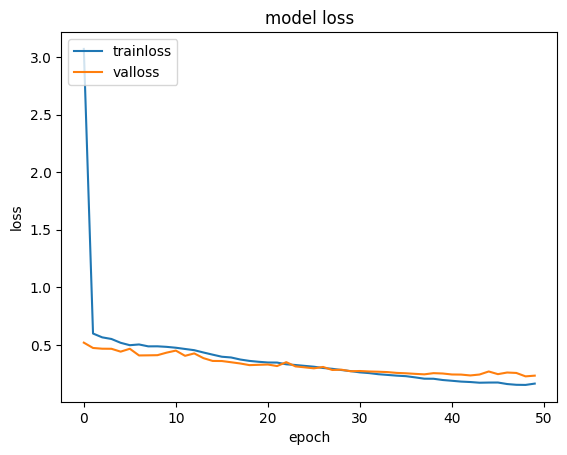

In [24]:
if __name__=="__main__":

    FLAGS = argparser()
    FLAGS.num_windows = [32]
    FLAGS.seq_window_lengths = [8,12]
    FLAGS.smi_window_lengths = [4,8]
    FLAGS.batch_size = 256
    FLAGS.num_epoch = 50
    FLAGS.max_seq_len = 1000
    FLAGS.max_smi_len = 100
    FLAGS.dataset_path = 'data/kiba/'
    FLAGS.problem_type = 1
    FLAGS.log_dir = 'logs/'+str(time.time()) + "/"

    if not os.path.exists(FLAGS.log_dir):
      os.makedirs(FLAGS.log_dir)

    logging(str(FLAGS), FLAGS)
    run_regression(FLAGS)